## Introduction

If you're interested in learning about object detection using KerasCV, I highly suggest
taking a look at the guide created by lukewood. This resource, available at
[Object Detection With KerasCV](https://keras.io/guides/keras_cv/object_detection_keras_cv/#object-detection-introduction),
provides a comprehensive overview of the fundamental concepts and techniques
required for building object detection models with KerasCV.

In [1]:
#!pip install --upgrade git+https://github.com/keras-team/keras-cv -q
#!pip install -q --upgrade keras-cv
#!pip install -q --upgrade tensorflow
#!pip install -q --upgrade keras --use-deprecated=legacy-resolver

In [2]:
#!wget https://universe.roboflow.com/ds/GG1XJhlbDK?key=FFxqUqVjub -O indoor_object_detection.zip

In [3]:
#!unzip "indoor_object_detection.zip" -d "dataset/"

## Setup

In [43]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras
from keras_core import ops, random

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import random as tf_random
from tensorflow import clip_by_value

In [5]:
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-01-31 10:27:21.427819: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 10:27:21.549784: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 10:27:21.549829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Load Data

## Hyperparameters

In [8]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 3
LEARNING_RATE = 0.001
EPOCH = 10
GLOBAL_CLIPNORM = 10.0
IMG_SIZE = 640
AUTO = tf_data.AUTOTUNE

A dictionary is created to map each class name to a unique numerical identifier. This
mapping is used to encode and decode the class labels during training and inference in
object detection tasks.

In [9]:
class_ids = [
    "TV", "bed", "chair", "clock", "console", "consoleeeeee", "door", "fan", "light", "sofa", "switchboard", "table"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "../dataset/train/"
path_annot = "../dataset/train/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

In [10]:

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/4660 [00:00<?, ?it/s]

In [11]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

2024-01-31 10:29:32.061827: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 10:29:32.061904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 10:29:32.061921: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 10:29:34.895622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-31 10:29:34.895667: I external/local_xla/xla/stream_executor

Splitting data in training and validation data

In [12]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [13]:
print(len(image_paths))
print(num_val)
print(train_data.__len__())

4660
932
tf.Tensor(3728, shape=(), dtype=int64)


In [14]:

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


In [15]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

## Creating Training Dataset

In [16]:
train_ds_one = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_one = train_ds_one.shuffle(BATCH_SIZE * 4)
train_ds_one = train_ds_one.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds_one = train_ds_one.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_two = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_two = train_ds_two.shuffle(BATCH_SIZE * 4)
train_ds_two = train_ds_two.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds_two = train_ds_two.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
print(train_ds_one)

<_ParallelMapDataset element_spec={'images': TensorSpec(shape=(3, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([3, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([3, None, None]), tf.float32, 1, tf.int64)}}>


In [18]:
# Combine two shuffled datasets from the same training data.
train_ds = tf_data.Dataset.zip((train_ds_one, train_ds_two))

In [39]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf_random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf_random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def get_box(lambda_value):
    cut_rat = ops.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = ops.cast(cut_w, "int32")

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = ops.cast(cut_h, "int32")

    cut_x = random.uniform((1,), minval=0, maxval=IMG_SIZE)  # rx
    cut_x = ops.cast(cut_x, "int32")
    cut_y = random.uniform((1,), minval=0, maxval=IMG_SIZE)  # ry
    cut_y = ops.cast(cut_y, "int32")

    boundaryx1 = clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


def cutmix(image1, image2):

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf_image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf_image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf_image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf_image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = ops.cast(lambda_value, "float32")

    # Combine the labels of both images
    #label = lambda_value * label1 + (1 - lambda_value) * label2
    return image

def cutmixbatch(obj1, obj2):
    imageb1 = obj1['images']
    imageb2 = obj2['images']
    print(imageb1)
    print(imageb1[0])
    print(imageb1.get_shape().as_list())
    ret = tf.Variable(imageb1.get_shape().as_list(), dtype="float32")
    indices = tf.range(imageb1.shape[0])
    tf.expand_dims(indeces, axis=0)
    print(indeces)
    tf.tensor_scatter_nd_update(ret, indeces, 

    #tensor = [0, 0, 0, 0, 0, 0, 0, 0]    # tf.rank(tensor) == 1
    #indices = [[1], [3], [4], [7]]       # num_updates == 4, index_depth == 1
    #updates = [9, 10, 11, 12]            # num_updates == 4
    #print(tf.tensor_scatter_nd_update(tensor, indices, updates))
    
    for i in range(imageb1.shape[0]):
        ret[i].assign(cutmix(imageb1[i], imageb2[i]))
    return ret, obj2

In [44]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmixbatch, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Tensor("args_2:0", shape=(3, 640, 640, 3), dtype=float32)
Tensor("strided_slice:0", shape=(640, 640, 3), dtype=float32)
[3, 640, 640, 3]
Tensor("args_2:0", shape=(3, 640, 640, 3), dtype=float32)
Tensor("strided_slice:0", shape=(640, 640, 3), dtype=float32)
[3, 640, 640, 3]


ValueError: in user code:

    File "/tmp/ipykernel_473/3588437186.py", line 88, in cutmixbatch  *
        ret = tf.Variable(imageb1.get_shape().as_list(), dtype="float32")

    ValueError: tf.function only supports singleton tf.Variables created on the first call. Make sure the tf.Variable is only created once or created outside tf.function. See https://www.tensorflow.org/guide/function#creating_tfvariables for more information.


## Creating Validation Dataset

In [ ]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Visualization

In [ ]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=1,
        cols=1,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds_cmu, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    train_ds_cmu, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

We need to extract the inputs from the preprocessing dictionary and get them ready to be
fed into the model.

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds_cmu = train_ds_cmu.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_cmu = train_ds_cmu.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

You can read more about YOLOV8 and its architecture in this
[RoboFlow Blog](https://blog.roboflow.com/whats-new-in-yolov8/)

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",  # We will use yolov8 small backbone with coco weights
    trainable = False
)

Next, let's build a YOLOV8 model using the `YOLOV8Detector`, which accepts a feature
extractor as the `backbone` argument, a `num_classes` argument that specifies the number
of object classes to detect based on the size of the `class_mapping` list, a
`bounding_box_format` argument that informs the model of the format of the bbox in the
dataset, and a finally, the feature pyramid network (FPN) depth is specified by the
`fpn_depth` argument.

It is simple to build a YOLOV8 using any of the aforementioned backbones thanks to
KerasCV.

In [ ]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3
)

In [ ]:
#for layer in yolo.layers:
#    if "yolo_v8_head" in layer.name:
#        print(layer.name + " - " + str(layer.trainable))
#        layer.trainable = True
#    else:
#        layer.trainable = False

## Compile the Model

Loss used for YOLOV8


1. Classification Loss: This loss function calculates the discrepancy between anticipated
class probabilities and actual class probabilities. In this instance,
`binary_crossentropy`, a prominent solution for binary classification issues, is
Utilized. We Utilized binary crossentropy since each thing that is identified is either
classed as belonging to or not belonging to a certain object class (such as a person, a
car, etc.).

2. Box Loss: `box_loss` is the loss function used to measure the difference between the
predicted bounding boxes and the ground truth. In this case, the Complete IoU (CIoU)
metric is used, which not only measures the overlap between predicted and ground truth
bounding boxes but also considers the difference in aspect ratio, center distance, and
box size. Together, these loss functions help optimize the model for object detection by
minimizing the difference between the predicted and ground truth class probabilities and
bounding boxes.


In [ ]:
#tf.keras.backend.clear_session()

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)
yolo.summary()

## COCO Metric Callback

We will be using `BoxCOCOMetrics` from KerasCV to evaluate the model and calculate the
Map(Mean Average Precision) score, Recall and Precision. We also save our model when the
mAP score improves.

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=False)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


In [ ]:
yolo.load_weights(model-ep14-01292024-014637.h5")
#yolo = keras_cv.models.load("model.h5")

In [ ]:
#yolo.save("model_3ep.h5")

## Train the Model

In [ ]:
yolo.fit(
    train_ds_cmu,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

## Visualize Predictions

In [ ]:

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(201)))
    print(images.shape)
    print(y_true)
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (0,0,255),
        pred_color = (0,255,0),
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

In [ ]:
print(val_ds.cardinality())

(1, 640, 640, 3)


2024-01-28 23:31:53.492731: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-28 23:31:56.043163: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-28 23:31:56.732204: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 14s 14s/step
{'boxes': <tf.RaggedTensor [[[55.538963, 275.30692, 366.1436, 503.42355],
  [291.89398, 358.99002, 611.8519, 606.4009],
  [295.80298, 394.45398, 564.8023, 594.4265]]]>, 'confidence': <tf.RaggedTensor [[0.5486799, 0.2899013, 0.2179333]]>, 'classes': <tf.RaggedTensor [[3.0, 3.0, 3.0]]>, 'num_detections': array([3], dtype=int32)}


IndexError: index 1 is out of bounds for axis 0 with size 1

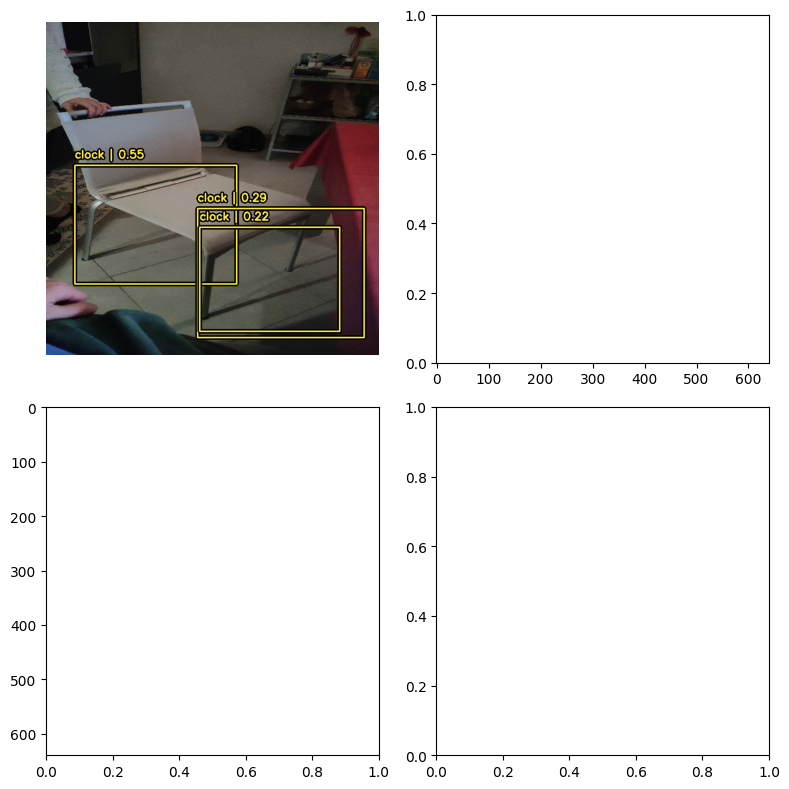

In [26]:
def visualize_generic(model, image_name, bounding_box_format):
    #images = load_image(os.path.join(path_images, image_name))
    image = tf.io.read_file(image_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [640,640])
    images = tf.cast(image, tf.float32)
    images = tf.expand_dims(images, axis=0)
    print(images.shape)

    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    print(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        #y_true={},
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_generic(yolo, image_name="testimage_2.jpg", bounding_box_format="xyxy")
#img_0120_jpg.rf.36da0f1b2f59ec13cb70e1b82defd9a0.jpg